<a href="https://colab.research.google.com/github/oorora67/AI-HandsOn/blob/master/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

begin searching クマ
-> found 10 images
-> downloading image 0001


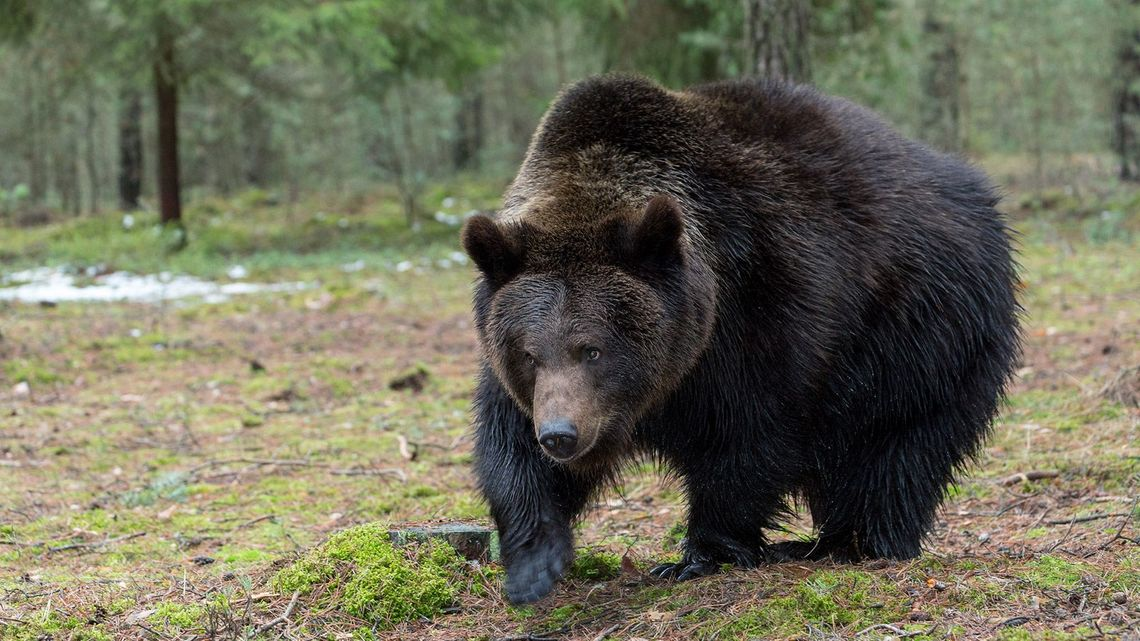

-> downloading image 0002


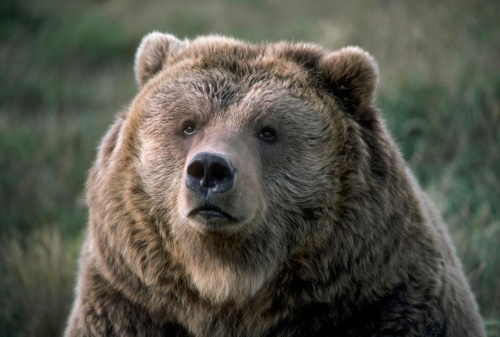

-> downloading image 0003


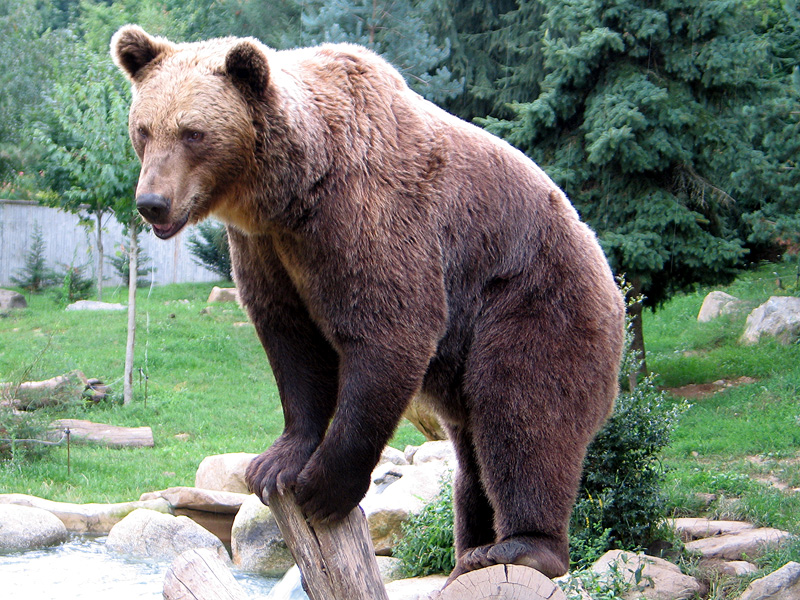

-> downloading image 0004


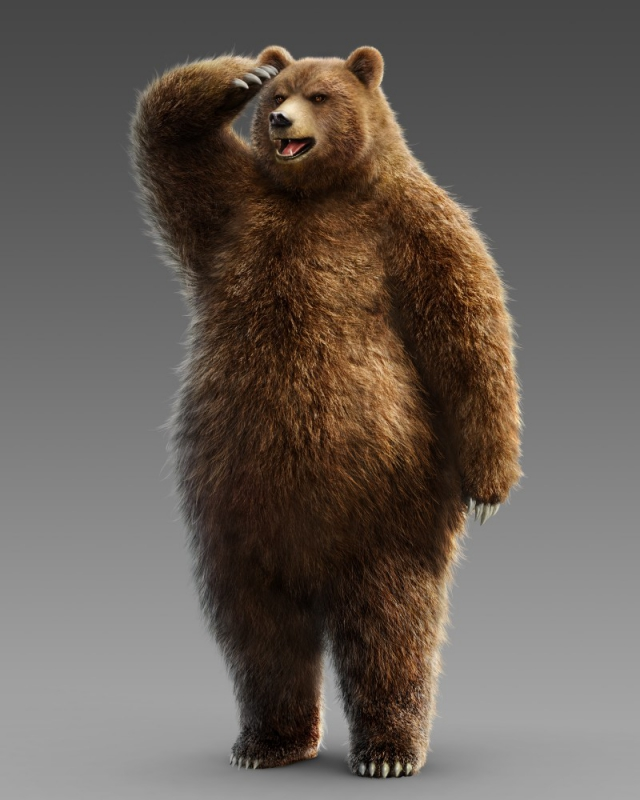

-> downloading image 0005


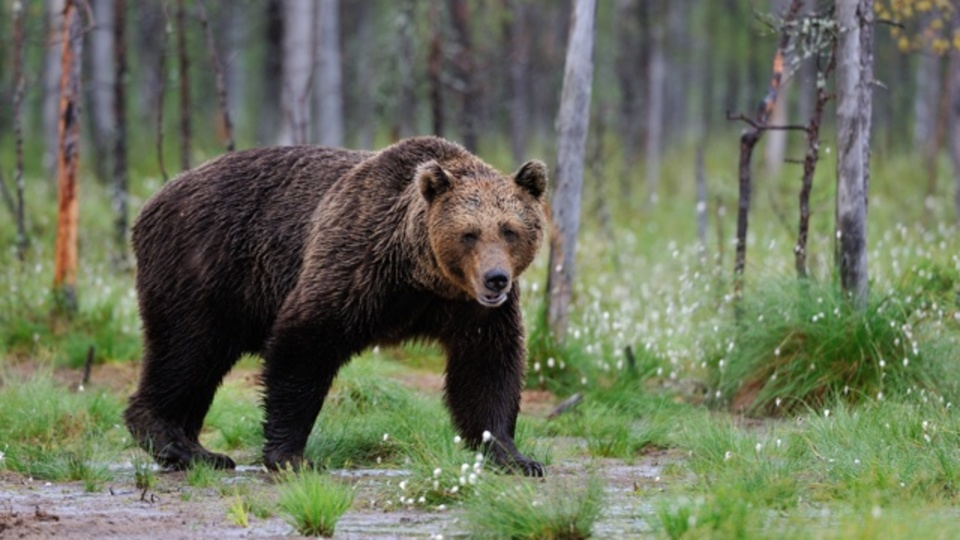

-> downloading image 0006


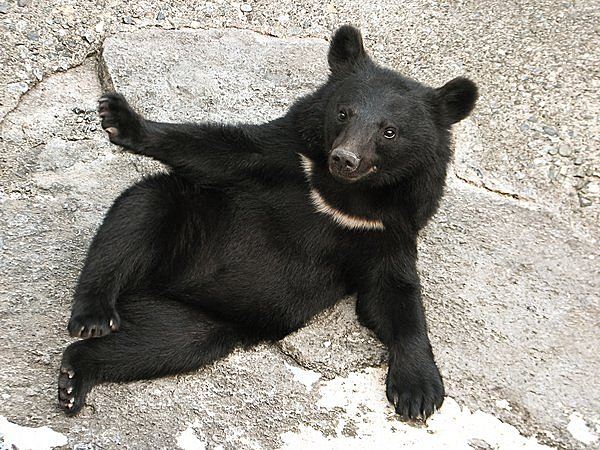

-> downloading image 0007


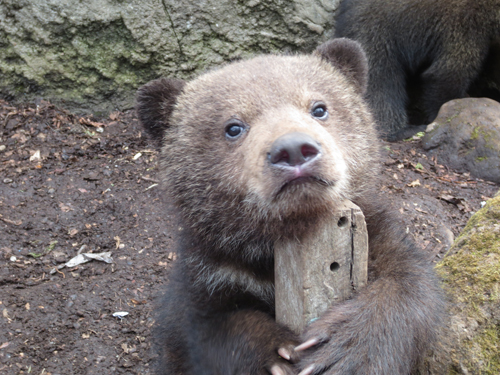

-> downloading image 0008


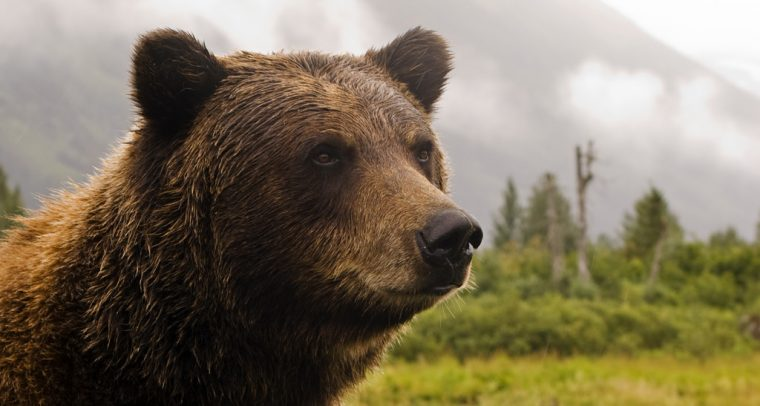

-> downloading image 0009


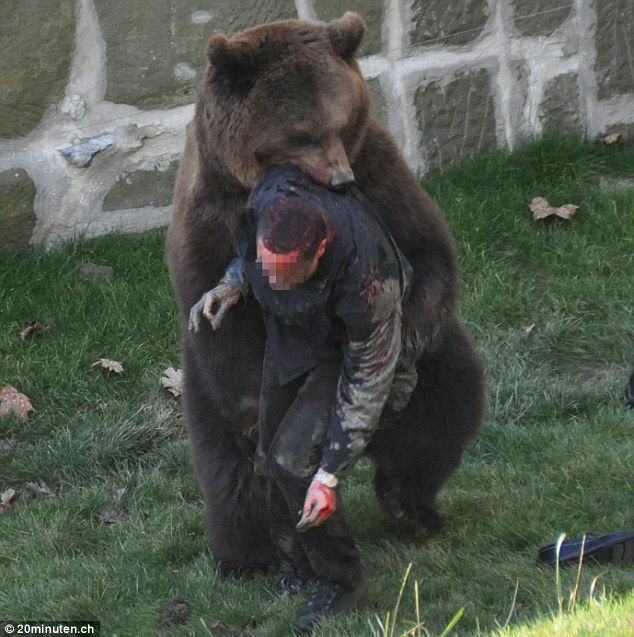

-> downloading image 0010


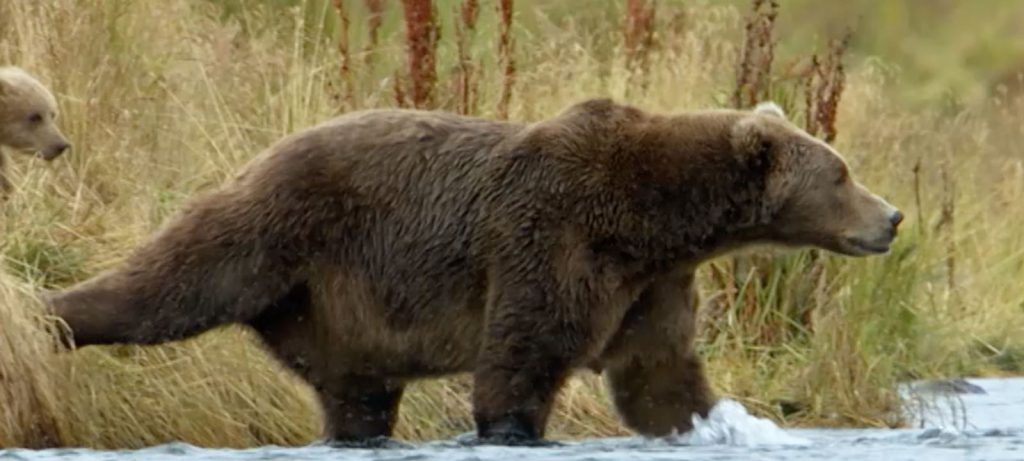

complete download
├─ download 10 images
└─ could not download 0 images []


In [0]:
import json
import os
import sys
import urllib
from IPython.display import Image,display_jpeg

from bs4 import BeautifulSoup
import requests
Search_Name = 'クマ'
Get_Number = 10

class Google:
    def __init__(self):
        self.GOOGLE_SEARCH_URL = 'https://www.google.co.jp/search'
        self.session = requests.session()
        self.session.headers.update(
            {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0'})

    def search(self, keyword, maximum):
        print('begin searching', keyword)
        query = self.query_gen(keyword)
        return self.image_search(query, maximum)

    def query_gen(self, keyword):
        # search query generator
        page = 0
        while True:
            params = urllib.parse.urlencode({
                'q': keyword,
                'tbm': 'isch',
                'ijn': str(page)})

            yield self.GOOGLE_SEARCH_URL + '?' + params
            page += 1

    def image_search(self, query_gen, maximum):
        # search image
        result = []
        total = 0
        while True:
            # search
            html = self.session.get(next(query_gen)).text
            soup = BeautifulSoup(html, 'lxml')
            elements = soup.select('.rg_meta.notranslate')
            jsons = [json.loads(e.get_text()) for e in elements]
            imageURLs = [js['ou'] for js in jsons]

            # add search result
            if not len(imageURLs):
                print('-> no more images')
                break
            elif len(imageURLs) > maximum - total:
                result += imageURLs[:maximum - total]
                break
            else:
                result += imageURLs
                total += len(imageURLs)

        print('-> found', str(len(result)), 'images')
        return result


def main():
    google = Google()
    # save location
    name = Search_Name
    data_dir = 'data/'
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs('data/' + name, exist_ok=True)

        # search image
    result = google.search(
    name, maximum=Get_Number)

        # download
    download_error = []
    for i in range(len(result)):
        print('-> downloading image', str(i + 1).zfill(4))
        try:
            urllib.request.urlretrieve(result[i], data_dir + name + '/' + str(i + 1).zfill(4) + '.jpg')
            display_jpeg(Image(data_dir + name + '/' + str(i + 1).zfill(4) + '.jpg'))
            continue
        except:
            print('--> could not download image', str(i + 1).zfill(4))
            download_error.append(i + 1)
            continue

    print('complete download')
    print('├─ download', len(result)-len(download_error), 'images')
    print('└─ could not download', len(download_error), 'images', download_error)


if __name__ == '__main__':
    main()

In [0]:

# Google ColabのGPU割り当て設定を確認する
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 150.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
!rm  -rf data/